In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2

import platform

In [3]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz


In [6]:
# setting seed for PRNGs
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
tf.test.gpu_device_name()
tf.__version__

'2.8.2'

# Lorenz System

In [8]:
from tools.misc_tools import create_Lorenz_data

In [9]:
# setting up params

from numpy import *

### Simutlation paramaters
dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_001'
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]

rho_arr = params_dict['rho_arr']
sigma_arr = params_dict['sigma_arr']
beta_arr = params_dict['beta_arr']

x0 = params_dict['x0']
y0 = params_dict['y0']
z0 = params_dict['z0']

t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']

normalize_flag = params_dict['normalize_flag']


### RNN paramaters
with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
    lines = f.readlines()

params_rnn_dict = eval(''.join(lines))

dt_rnn = params_rnn_dict['dt_rnn']
T_sample_input = params_rnn_dict['T_sample_input']
T_sample_output = params_rnn_dict['T_sample_output']
T_offset = params_rnn_dict['T_offset']
return_params_arr = params_rnn_dict['return_params_arr']

In [10]:
res_dict = create_Lorenz_data(
    T, t0, delta_t,
    rho_arr, sigma_arr, beta_arr,
    x0, y0, z0, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']

if return_params_arr == True:
    params_arr = res_dict['params_arr']

if normalize_flag == True:
    normalization_constant_arr = res_dict['normalization_constant_arr']

In [11]:
n = len(boundary_idx_arr)

# Autoencoder

In [12]:
from tools.ae_v3 import Autoencoder

In [13]:
# load_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_class_dict.txt'
# wt_file = dir_name_ae+dir_sep+'new_class_data'+dir_sep+'ae_'+ae_idx+'_ae_weights.h5'

load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [14]:
ae_net = Autoencoder(6, load_file=load_file)
ae_net.load_weights_from_file(wt_file)

In [15]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

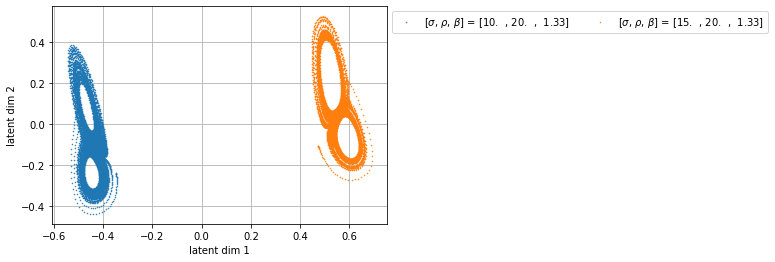

In [16]:
# plotting latent states
prev_idx = 0
# plt_idx = 27
# for i in range(plt_idx,plt_idx+1):
for i in range(len(boundary_idx_arr)):
    next_idx = boundary_idx_arr[i]
    plt.plot(
        latent_states_all[prev_idx:next_idx, 0],
        latent_states_all[prev_idx:next_idx, 1],
        linewidth=0,
        marker='.',
        color='C'+str(i),
        markersize=1,
#         label=r'[$\sigma$, $\rho$, $\beta$] = {:.2f}'.format([i for i in all_data[next_idx-1, 3:]])# + str(all_data[next_idx-1, 3:])
#         label=r'[$\sigma$, $\rho$, $\beta$] = '+str(all_data[next_idx-1, 3:])
        label=r'[$\sigma$, $\rho$, $\beta$] = ' + np.array2string(all_data[next_idx-1, 3:], precision=2, separator=', ')
    )
    prev_idx = next_idx

# plt.xlim([-1,1])
# plt.ylim([-1,1])
plt.grid(True)
plt.xlabel('latent dim 1')
plt.ylabel('latent dim 2')
plt.legend(bbox_to_anchor=(1,1), ncol=3)
# plt.savefig(dir_name_ae+'/plots/latent_space.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# LSTM

In [18]:
# create data
# latent_states_all = net.encoder_net.predict(all_data)

In [19]:
from tools.misc_tools import create_data_for_RNN

In [20]:
if return_params_arr != False:
    params = params_arr
else:
    params = None

data_rnn_input, data_rnn_output, org_data_idx_arr_input, org_data_idx_arr_output = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    N,
    boundary_idx_arr,
    delta_t,
    params=params)

In [21]:
train_split = 0.9
test_split = 1 - train_split
val_split = 0.1

In [22]:
idx = np.arange(data_rnn_input.shape[0])
np.random.shuffle(idx)
boundary = int(np.round(train_split*data_rnn_input.shape[0]))

training_data_rnn_input = data_rnn_input[idx[0:boundary]]
training_data_rnn_output = data_rnn_output[idx[0:boundary]]

testing_data_rnn_input = data_rnn_input[idx[boundary:]]
testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [23]:
boundary

16274

In [24]:
train_dataset_rnn_input = tf.data.Dataset.from_tensor_slices(training_data_rnn_input)
train_dataset_rnn_output = tf.data.Dataset.from_tensor_slices(training_data_rnn_output)

BATCH_SIZE = 64

# train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
# train_dataset_rnn = train_dataset_rnn.batch(BATCH_SIZE)
# test_dataset_rnn = test_dataset_rnn.batch(BATCH_SIZE)

In [25]:
# Training parameters
learning_rate_list = [0.001, 0.0001, 0.00001]
epochs = 2000
patience = 20  # parameter for early stopping
min_delta = 1e-6  # parameter for early stopping
lambda_reg = 1e-5  # weight for regularizer

In [26]:
from tools.LSTM_SingleStep_v1 import RNN_LSTM

In [27]:
# Initialize network
rnn_layers_units = [2**7]*8
if return_params_arr != False:
    data_dim = 5
else:
    data_dim = 2

rnn_net = RNN_LSTM(
    data_dim=data_dim,
#     in_steps=int(T_sample_input // dt_rnn),
#     out_steps=int(T_sample_output // dt_rnn),
    dt_rnn=dt_rnn,
    lambda_reg=lambda_reg,
    reg_name='L2',
    rnn_layers_units=rnn_layers_units,
    dense_layer_act_func='linear',
    load_file=None
)

In [28]:
temp = rnn_net(tf.ones(shape=[BATCH_SIZE, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
rnn_net.load_weights(dir_name_rnn+'{ds}checkpoints{ds}checkpoints'.format(ds=dir_sep))

In [29]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

# implementing early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
    verbose=True,
    min_delta=min_delta
)

# time callback for each epoch
class mytimecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.total_time = 0
        self.start_time = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.total_time = time.time() - self.start_time
        print(' - tot_time: {:.0f}h {:.0f}m {:.1f}s'.format(self.total_time//3600, (self.total_time//60)%60, self.total_time%60))
#     def on_train_end(self,logs = {}):
#         plt.xlabel('Epoch')
#         plt.ylabel('Total time taken until an epoch in seconds')
#         plt.plot(*zip(*self.times))
#         plt.show()
timekeeper_cb = mytimecallback()

# model checkpoint callback
dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
if not os.path.isdir(dir_name_ckpt):
    os.makedirs(dir_name_ckpt)
# if current_sys == 'Windows':
dir_name_ckpt += '{ds}checkpoints'.format(ds=dir_sep)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=dir_name_ckpt,#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2,
    period=5  # saves every 5 epochs
)

# training the network
val_loss_hist = []
train_loss_hist = []
lr_change=[0]
for i in range(len(learning_rate_list)):
    learning_rate = learning_rate_list[i]
    
    total_s_len = 80
    sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
    print('\n\n' + '-'*len(sep_lr_s))
    print('\n' + sep_lr_s+'\n')
    print('-'*len(sep_lr_s) + '\n\n')
    
    K.set_value(rnn_net.optimizer.lr, learning_rate)

    history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
        epochs=epochs,
        batch_size=BATCH_SIZE,
        validation_split=val_split/train_split,
        callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb],
        verbose=1
    )

    val_loss_hist.extend(history.history['val_loss'])
    train_loss_hist.extend(history.history['loss'])
    
    lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
227/227 [==============================] - 184s 772ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 2/2000
227/227 [==============================] - 169s 746ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 3/2000
227/227 [==============================] - 172s 756ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 4/2000
227/227 [==============================] - 173s 761ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/2000
227/227 [==============================] - ETA: 0s - loss: 0.0011 - tot_time: 0h 14m 29.8s

Epoch 5: val_loss improved from inf to 0.00109, saving model to /content/drive/MyDrive/Colab Notebooks/Thesis/Lorenz/saved_rnn/rnn_001/checkpoints/checkpoints
227/227 [==============================] - 172s 757ms/step - lo

In [30]:
save_path = dir_name_rnn+dir_sep+'final_net'

if not os.path.isdir(save_path):
    os.makedirs(save_path)

with open(save_path+dir_sep+'losses.txt', 'w') as f:
    f.write(str({
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'lr_change':lr_change
    }))

rnn_net.save_everything(file_name=save_path+dir_sep+'final_net')

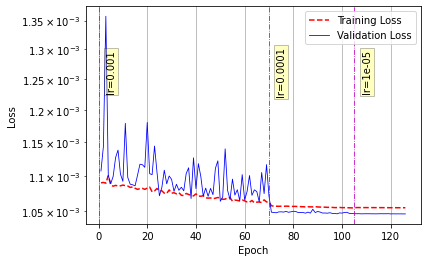

In [31]:
# plotting losses

# Get training and test loss histories
training_loss = train_loss_hist
val_loss = val_loss_hist

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# lr_change = [0, 987, 987+334]
# for i in range(1,len(lr_change)):
#     lr_change[i] += lr_change[i-1]

# Visualize loss history
plt.semilogy(epoch_count, training_loss, 'r--')
plt.semilogy(epoch_count, val_loss, 'b-', linewidth=0.8)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
for i in range(len(lr_change)-1):
    plt.axvline(lr_change[i], color='m', linestyle='-.', linewidth=0.8)
    plt.text(
        # lr_change[i]+20,
        lr_change[i]+plt.gca().transData.inverted().transform(plt.gca().transAxes.transform([0.06, 0.7]))[0],
        plt.gca().transData.inverted().transform(plt.gca().transAxes.transform([0.5, 0.7]))[1],
        'lr={}'.format(learning_rate_list[i]),
        rotation=90,
        verticalalignment='center',
        horizontalalignment='left',
        bbox=dict(facecolor='yellow', alpha=0.25, boxstyle='square,pad=0.2')
    )
plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()

In [32]:
# # net.predict(rnn_net.predict(testing_data_rnn_input[0:1]))
# # # training_data_rnn_input[0].shape

# net_loss = 0.0
# counter = 0
# for i in range(training_data_rnn_input.shape[0]):
#     rnn_data_org_idx = idx[i]
#     all_data_org_idxes = org_data_idx_arr_input[rnn_data_org_idx]

#     # params = all_data[all_data_org_idxes[0], 3:]
#     ideal_decoder_outputs = all_data[all_data_org_idxes, :]

#     lstm_pred_latent_states = rnn_net.predict(training_data_rnn_input[i:i+1])
#     decoder_pred = np.array([net.decoder_net.predict(lstm_pred_latent_states[0, i].reshape((1, 2))) for i in range(lstm_pred_latent_states.shape[1])])

#     mse = (np.sum((decoder_pred - ideal_decoder_outputs)**2, axis=1)/ideal_decoder_outputs.shape[1])**0.5
#     mse = np.sum(mse) / mse.shape[0]
    
#     net_loss += mse
#     counter += 1

# net_loss /= counter
# print('net_loss : {}'.format(net_loss))

# AE-RNN Combination

In [33]:
# setting up the RNN class
class AE_RNN_v1(Model):
    """
    AE-RNN that advances (in time) the latent space representation
    """
    def __init__(self, encoder_net, decoder_net, rnn_net):
        
        super(AE_RNN_v1, self).__init__()

        self.encoder_net = encoder_net
        self.decoder_net = decoder_net
        self.rnn_net = rnn_net

        return

    def call(self, x):

        output = layers.TimeDistributed(self.encoder_net)(x)
        output = self.rnn_net(output)
        output = layers.TimeDistributed(self.decoder_net)(output)

        return output

In [34]:
# setting up the RNN class
class AE_RNN_v2(Model):
    """
    AE-RNN that advances (in time) the latent space representation
    """
    def __init__(self, encoder_net, decoder_net, rnn_net):
        
        super(AE_RNN_v2, self).__init__()

        self.encoder_net = encoder_net
        self.decoder_net = decoder_net
        self.rnn_net = rnn_net

        return

    def call(self, x):

        if type(x) != np.ndarray:
            x = x.numpy()
        
        params = x[:, :, 3:].copy()
        
        output = layers.TimeDistributed(self.encoder_net)(x)
        
        temp_ = np.empty(shape=(output.shape[0], output.shape[1], output.shape[2]+3))
        temp_[:, :, 0:-3] = output.numpy()[:, :, :]
        temp_[:, :, -3:] = params[:, :, :]
        output = tf.convert_to_tensor(temp_)
        
        output = self.rnn_net(output)
        
        temp_ = np.empty(shape=(output.shape[0], output.shape[1], output.shape[2]-3))
        temp_[:, :, :] = output.numpy()[:, :, 0:-3]
        output = tf.convert_to_tensor(temp_)
        
        output = layers.TimeDistributed(self.decoder_net)(output)

        return output

In [35]:
# ae_rnn = AE_RNN_v2(net.encoder_net, net.decoder_net, rnn_net)

In [36]:
# T_input = dt_rnn
# T_output = 25
# num_input = 1 # int(T_input // dt_rnn)
# num_output = num_sample_output # int(T_output // dt_rnn)

# for i in range(len(boundary_idx_arr)):
#     u_input = all_data[i*N+0:i*N+0 + idx_to_skip*num_input:idx_to_skip, :].reshape(1, num_input, 6)
#     output_exact = all_data[N*i+idx_to_skip*num_input:i*N+ idx_to_skip*(num_input+num_output):idx_to_skip]
#     output_predicted = ae_rnn(u_input)
    
#     fig, ax = plt.subplots(3, 1, sharex=True)
#     ax_ylabels = ['x', 'y', 'z']
#     for j in range(3):
#         input_time = np.arange(0,dt_rnn*num_input, dt_rnn)
#         output_time = np.arange(input_time[-1]+dt_rnn, input_time[-1]+dt_rnn + dt_rnn*num_output, dt_rnn)
        
#         ax[j].plot(input_time, u_input[0, :, j], marker='x', color='k', markersize=3)
#         ax[j].plot(output_time, output_exact[:, j], marker='.', linewidth=0.8)
#         ax[j].plot(output_time, output_predicted[0, :, j], marker='^', linewidth=0.8)
        
#         ax[j].grid()
#         ax[j].set_ylabel(ax_ylabels[j])
        
#         fig.suptitle(r'[$\sigma$, $\rho$, $\beta$] = ' + str(all_data[i*N, 3:]))

In [37]:
# type(u_input) == np.ndarray